# Time Series Prediction with Knowledge Based Deep Learning ($KDL$)



AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-12 15:52:24

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Pretraining

_Lienard intermittancy_

The `lienard_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Lienard System

In [3]:
data = np.genfromtxt('datasets/lienard_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 0.0416 # Hourly Data (1/24)
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

1.00123132
1         0.000120
2         0.000239
3         0.000357
4         0.000473
5         0.000586
            ...   
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
139871    0.000000
Name: 1, Length: 139871, dtype: float64
2         0.002860
3         0.002843
4         0.002774
5         0.002716
6         0.002618
            ...   
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
139871    0.000000
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_KYOTO DST_

In [5]:
data = pd.read_csv("datasets/dst.csv")
training_set = data.iloc[:, 1]
print(training_set)

0         -7
1        -10
2        -10
3         -6
4         -2
          ..
139867   -16
139868   -14
139869   -14
139870   -15
139871   -14
Name: dst, Length: 139872, dtype: int64


In [6]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0         0.000120
1         0.000239
2         0.000357
3         0.000473
4         0.000586
            ...   
139866    0.000000
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
Name: 1, Length: 139871, dtype: float64
0         0.002860
1         0.002843
2         0.002774
3         0.002716
4         0.002618
            ...   
139865    0.000000
139866    0.000000
139867    0.000000
139868    0.000000
139869    0.000000
Name: 1, Length: 139870, dtype: float64


In [7]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Preprocessing the data into supervised learning

In [8]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)  # ,18,19
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        -7.0      -10.0      -10.0       -6.0       -2.0        3.0   
11       -10.0      -10.0       -6.0       -2.0        3.0        5.0   
12       -10.0       -6.0       -2.0        3.0        5.0        5.0   
13        -6.0       -2.0        3.0        5.0        5.0        3.0   
14        -2.0        3.0        5.0        5.0        3.0        1.0   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)   var3(t)  
10        5.0        5.0        3.0        1.0      1.0  0.001159  0.001722  
11        5.0        3.0        1.0        1.0      2.0  0.001231  0.001508  
12        3.0        1.0        1.0        2.0      2.0  0.001294  0.001277  
13        1.0        1.0        2.0        2.0      3.0  0.001347  0.001034  
14        1.0        2.0        2.0        3.0      3.0  0.001390  0.000774  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 

## Train and Test Split

In [9]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(111888, 1, 10) (111888, 3) (27972, 1, 10) (27972, 3)


## Model ($KDL$)

In [10]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
1749/1749 [==============================] - 7s 3ms/step - loss: 0.0051 - val_loss: 1.0992e-04
Epoch 2/500
1749/1749 [==============================] - 5s 3ms/step - loss: 7.4206e-04 - val_loss: 4.6411e-05
Epoch 3/500
1749/1749 [==============================] - 5s 3ms/step - loss: 6.1346e-04 - val_loss: 3.1786e-05
Epoch 4/500
1749/1749 [==============================] - 5s 3ms/step - loss: 5.8888e-04 - val_loss: 2.6502e-05
Epoch 5/500
1749/1749 [==============================] - 10s 6ms/step - loss: 5.7049e-04 - val_loss: 2.3607e-05
Epoch 6/500
1749/1749 [==============================] - 9s 5ms/step - loss: 5.5273e-04 - val_loss: 2.6736e-05
Epoch 7/500
1749/1749 [==============================] - 9s 5ms/step - loss: 5.3744e-04 - val_loss: 3.7244e-05
Epoch 8/500
1749/1749 [==============================] - 7s 4ms/step - loss: 5.2483e-04 - val_loss: 4.2432e-05
Epoch 9/500
1749/1749 [==============================] - 6s 3ms/step - loss: 5.1508e-04 - val_loss: 4.1732e-05
Epoc

## Metrics ($KDL$)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

875/875 [==============================] - 5s 4ms/step
(27972, 3)
(27972, 10)
Test RMSE: 2.644
Test MAE: 1.844


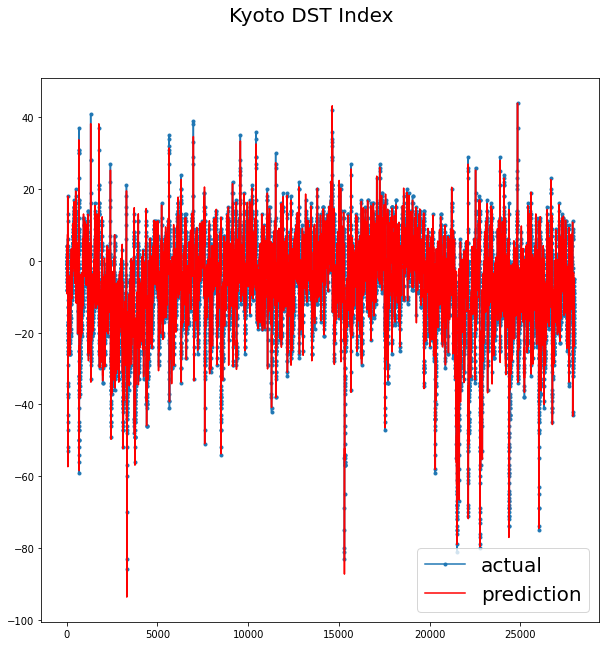

In [12]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('Kyoto DST Index', fontsize=20)
plt.legend(fontsize=20)
plt.show()